In [1]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem
from IPython.display import Image

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%reload_ext rpy2.ipython

In [4]:
%%R 
library(ggplot2)
library(grid)

In [5]:
empo3_dir = '/home/qiime2/empo-3-2'

In [6]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results')):
        continue
    type_ = os.path.basename(type_dir)
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            samples = json.load(fh)
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [7]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])

In [8]:
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')

In [9]:
prf = prf.join(abundances, ['sample type', 'sample'])

In [10]:
folds.head()

,sample type,sample,fold
0,animal-distal-gut,11405.subject233.timepoint24.60671,3
1,animal-distal-gut,10352.MIC20310411.57838,3
2,animal-distal-gut,1924.Sadowsky.39.56964,3
3,animal-distal-gut,10184.10460521.61426,3
4,animal-distal-gut,11757.G441284120.58900,3


In [11]:
folds = folds.set_index(['sample type', 'sample'])
prf = prf.join(folds, ['sample type', 'sample'])
prf.head()

,Unnamed: 0,level,Precision,Recall,F-measure,method,class weights,sample type,sample,abundance,fold
0,0,1,1.000000,0.999989,0.999995,weighted,RandomForest/26-none-100-sqrt-0.7,animal-distal-gut,10352.MIC20130521.57838,94949,3
1,1,2,0.997655,0.927645,0.961377,weighted,RandomForest/26-none-100-sqrt-0.7,animal-distal-gut,10352.MIC20130521.57838,94949,3
2,2,3,0.997541,0.897282,0.944759,weighted,RandomForest/26-none-100-sqrt-0.7,animal-distal-gut,10352.MIC20130521.57838,94949,3
3,3,4,0.997528,0.892353,0.942014,weighted,RandomForest/26-none-100-sqrt-0.7,animal-distal-gut,10352.MIC20130521.57838,94949,3
4,4,5,0.996590,0.843347,0.913587,weighted,RandomForest/26-none-100-sqrt-0.7,animal-distal-gut,10352.MIC20130521.57838,94949,3


In [12]:
len(set(prf['sample']))

22454

In [13]:
prf = prf[prf['method'] == 'weighted']
# If choose only level 7 (species), uncomment below
# level7 = prf[(prf['level'] == 7)]

In [14]:
grouped = prf.groupby(['sample type', 'class weights', 'fold', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [15]:
grouped = figure1.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [16]:
# Show level 1-7 of the best Random Forest classifier
rf_7levels = figure1[figure1['class weights']=='RandomForest/28-none-100-none-0.6']
rf_7levels

,sample type,class weights,level,mean,lower,upper
84,animal-distal-gut,RandomForest/28-none-100-none-0.6,1,0.999896,0.999835,0.999957
85,animal-distal-gut,RandomForest/28-none-100-none-0.6,2,0.986646,0.985934,0.987357
86,animal-distal-gut,RandomForest/28-none-100-none-0.6,3,0.981888,0.980926,0.982850
87,animal-distal-gut,RandomForest/28-none-100-none-0.6,4,0.977691,0.976616,0.978765
88,animal-distal-gut,RandomForest/28-none-100-none-0.6,5,0.943685,0.943101,0.944269
89,animal-distal-gut,RandomForest/28-none-100-none-0.6,6,0.871640,0.867564,0.875716
90,animal-distal-gut,RandomForest/28-none-100-none-0.6,7,0.803819,0.798818,0.808819


In [17]:
# Show only level 7 of each parameter set
prf = figure1[(figure1['level'] == 7)]
df = prf.sort_values(by="mean")
df['F-measure'] = df['mean']
df.sort_values(by="mean")

,sample type,class weights,level,mean,lower,upper,F-measure
153,animal-distal-gut,RandomForest/9-16-1000-sqrt-0.8,7,0.537635,0.532884,0.542386,0.537635
104,animal-distal-gut,RandomForest/3-16-100-sqrt-0.8,7,0.540503,0.535108,0.545897,0.540503
13,animal-distal-gut,RandomForest/12-16-1000-none-0.8,7,0.585775,0.583888,0.587662,0.585775
132,animal-distal-gut,RandomForest/6-16-100-none-0.8,7,0.600182,0.593129,0.607234,0.600182
62,animal-distal-gut,RandomForest/2-16-100-sqrt-0.7,7,0.608448,0.605114,0.611781,0.608448
146,animal-distal-gut,RandomForest/8-16-1000-sqrt-0.7,7,0.608947,0.605313,0.612582,0.608947
125,animal-distal-gut,RandomForest/5-16-100-none-0.7,7,0.635680,0.629994,0.641366,0.635680
139,animal-distal-gut,RandomForest/7-16-1000-sqrt-0.6,7,0.653332,0.648175,0.658488,0.653332
6,animal-distal-gut,RandomForest/1-16-100-sqrt-0.6,7,0.654878,0.650200,0.659556,0.654878
118,animal-distal-gut,RandomForest/4-16-100-none-0.6,7,0.656048,0.650498,0.661598,0.656048


In [18]:
# show only important data > dataset, classifier, species level and F-measure scores
df.drop(['mean','lower','upper'],axis=1)

,sample type,class weights,level,F-measure
153,animal-distal-gut,RandomForest/9-16-1000-sqrt-0.8,7,0.537635
104,animal-distal-gut,RandomForest/3-16-100-sqrt-0.8,7,0.540503
13,animal-distal-gut,RandomForest/12-16-1000-none-0.8,7,0.585775
132,animal-distal-gut,RandomForest/6-16-100-none-0.8,7,0.600182
62,animal-distal-gut,RandomForest/2-16-100-sqrt-0.7,7,0.608448
146,animal-distal-gut,RandomForest/8-16-1000-sqrt-0.7,7,0.608947
125,animal-distal-gut,RandomForest/5-16-100-none-0.7,7,0.635680
139,animal-distal-gut,RandomForest/7-16-1000-sqrt-0.6,7,0.653332
6,animal-distal-gut,RandomForest/1-16-100-sqrt-0.6,7,0.654878
118,animal-distal-gut,RandomForest/4-16-100-none-0.6,7,0.656048


In [19]:
# value 1 is just a dummy
# dummy in 'max_features' must be str, otherwise it fails.
random_forest = df
random_forest.insert(loc=0, column='max_depth', value='a')
random_forest.insert(loc=0, column='max_features', value='a')
random_forest.insert(loc=0, column='n_estimators', value=1)
random_forest.insert(loc=0, column='confidence', value='a')

In [20]:
# iterate through data frame to update parameters
for i, r in random_forest.iterrows():
    r1 = r['class weights'].split('-')
    max_depth = str(r1[1])
    n_estimators = str(r1[2])
    max_features = str(r1[3])
    confidence = str(r1[4])
    random_forest.at[i,'max_depth'] = max_depth
    random_forest.at[i,'n_estimators'] = n_estimators
    random_forest.at[i,'max_features'] = max_features
    random_forest.at[i,'confidence'] = confidence

In [21]:
# Get naive Bayes results from different directory

empo3_dir = '/home/qiime2/empo-3-3'
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results')):
        continue
    type_ = os.path.basename(type_dir)
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            samples = json.load(fh)
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
prf = prf.join(abundances, ['sample type', 'sample'])

folds = folds.set_index(['sample type', 'sample'])
prf = prf.join(folds, ['sample type', 'sample'])

prf = prf[prf['method'] == 'weighted']

grouped = prf.groupby(['sample type', 'class weights', 'fold', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

grouped = figure1.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [22]:
# Show level 1-7 of the best naive Bayes
nb_7levels = figure1[figure1['class weights']=='RandomForest/nb-0.6']
nb_7levels

,sample type,class weights,level,mean,lower,upper
0,animal-distal-gut,RandomForest/nb-0.6,1,1.000000,1.000000,1.000000
1,animal-distal-gut,RandomForest/nb-0.6,2,0.999256,0.999140,0.999372
2,animal-distal-gut,RandomForest/nb-0.6,3,0.998392,0.998305,0.998478
3,animal-distal-gut,RandomForest/nb-0.6,4,0.997987,0.997882,0.998091
4,animal-distal-gut,RandomForest/nb-0.6,5,0.972866,0.971959,0.973773
5,animal-distal-gut,RandomForest/nb-0.6,6,0.922033,0.919104,0.924963
6,animal-distal-gut,RandomForest/nb-0.6,7,0.886213,0.883224,0.889202


In [23]:
# Show only level 7 of each confidence
prf = figure1[(figure1['level'] == 7)]
df2 = prf.sort_values(by="mean")
df2['F-measure'] = df2['mean']
df2.sort_values(by="mean")

,sample type,class weights,level,mean,lower,upper,F-measure
20,animal-distal-gut,RandomForest/nb-0.8,7,0.877778,0.875298,0.880257,0.877778
13,animal-distal-gut,RandomForest/nb-0.7,7,0.884208,0.881791,0.886625,0.884208
6,animal-distal-gut,RandomForest/nb-0.6,7,0.886213,0.883224,0.889202,0.886213


In [24]:
# show only important data > dataset, classifier, species level and F-measure scores
df2.drop(['mean','lower','upper'],axis=1)

,sample type,class weights,level,F-measure
20,animal-distal-gut,RandomForest/nb-0.8,7,0.877778
13,animal-distal-gut,RandomForest/nb-0.7,7,0.884208
6,animal-distal-gut,RandomForest/nb-0.6,7,0.886213


In [25]:
random_forest = df.sort_values('max_depth')
naive_bayes = df2

## Seaborn and matplotlib are used for plotting.

(0.6, 1.05)

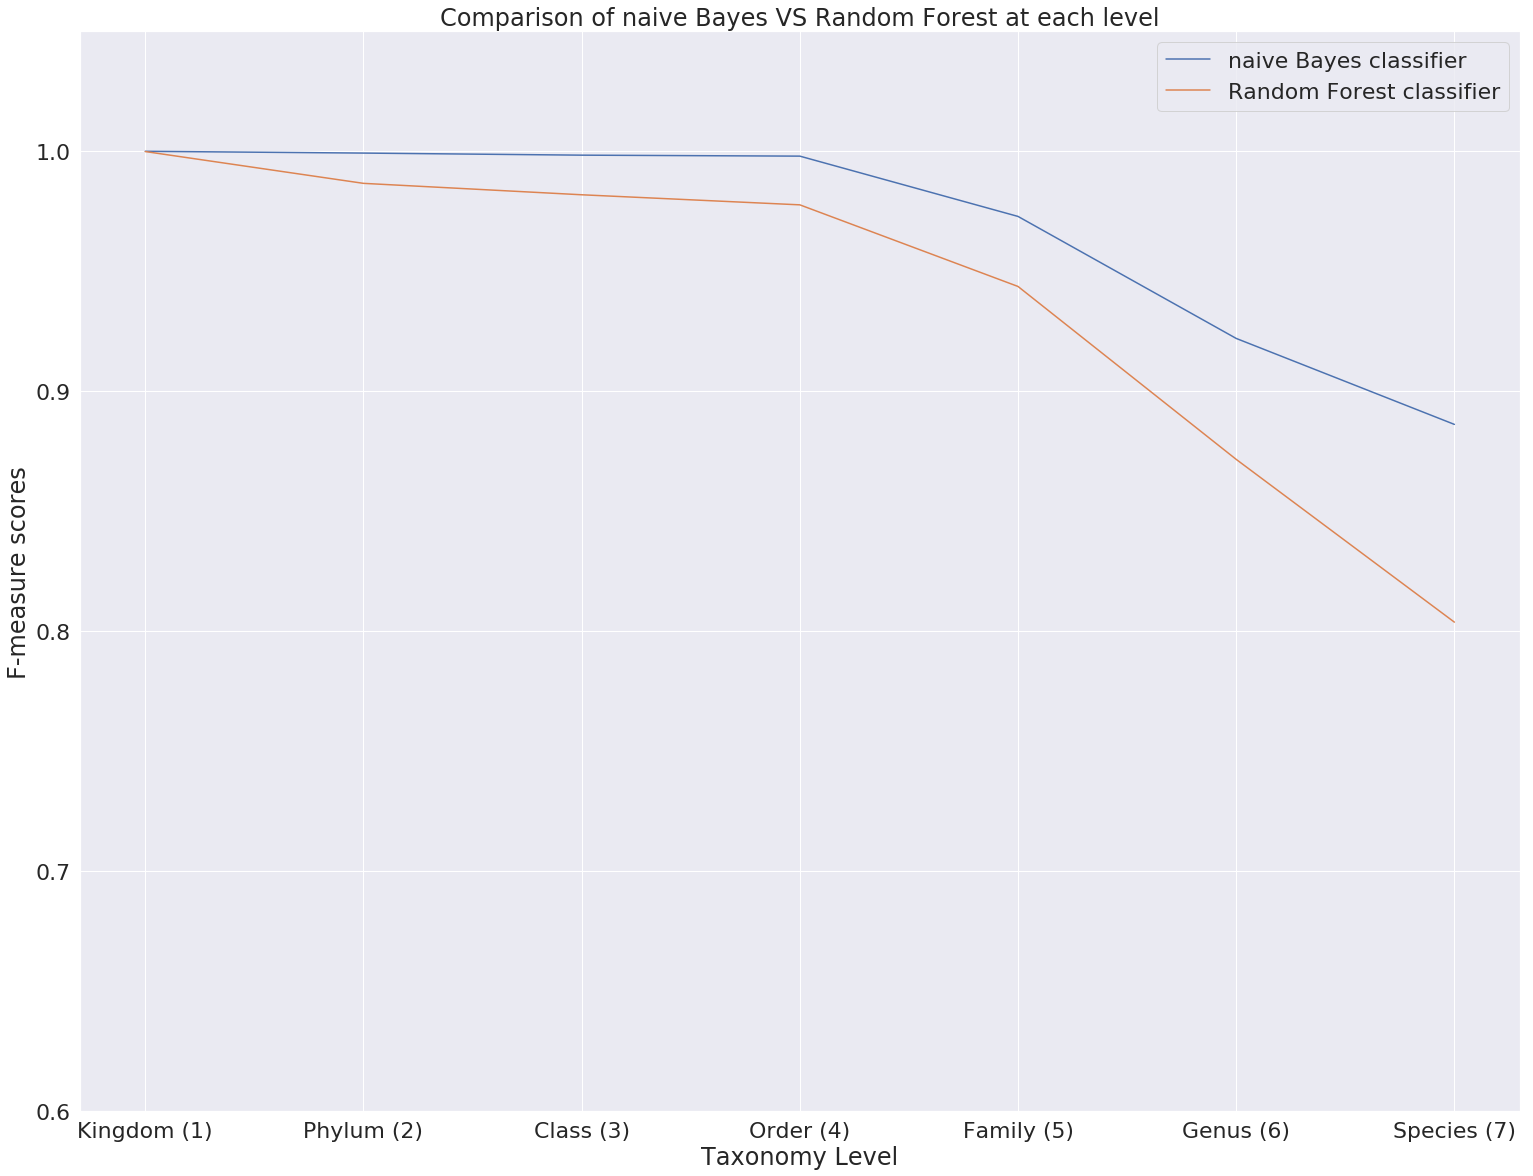

In [30]:
# Comparison of the optimized naive Bayes classifier and the best Random Forest classifier
# at each level of biology classification
fig = plt.figure()
taxa = ['Kingdom (1)','Phylum (2)','Class (3)','Order (4)','Family (5)','Genus (6)','Species (7)']

ax = fig.add_axes([0,0,1,1])
ax.plot(taxa, nb_7levels['mean'].tolist(),label='naive Bayes classifier')
ax.plot(taxa, rf_7levels['mean'].tolist(),label='Random Forest classifier')
ax.legend()
ax.set_xlabel('Taxonomy Level')
ax.set_ylabel('F-measure scores')
ax.set_title('Comparison of naive Bayes VS Random Forest at each level')
ax.set_ylim([0.6,1.05])

Naive Bayse F-measure Median = 0.8842083276799653
n_estimator=100 F-measure Median = 0.604314802233558
n_estimator=1000 F-measure Median = 0.5973611498952184


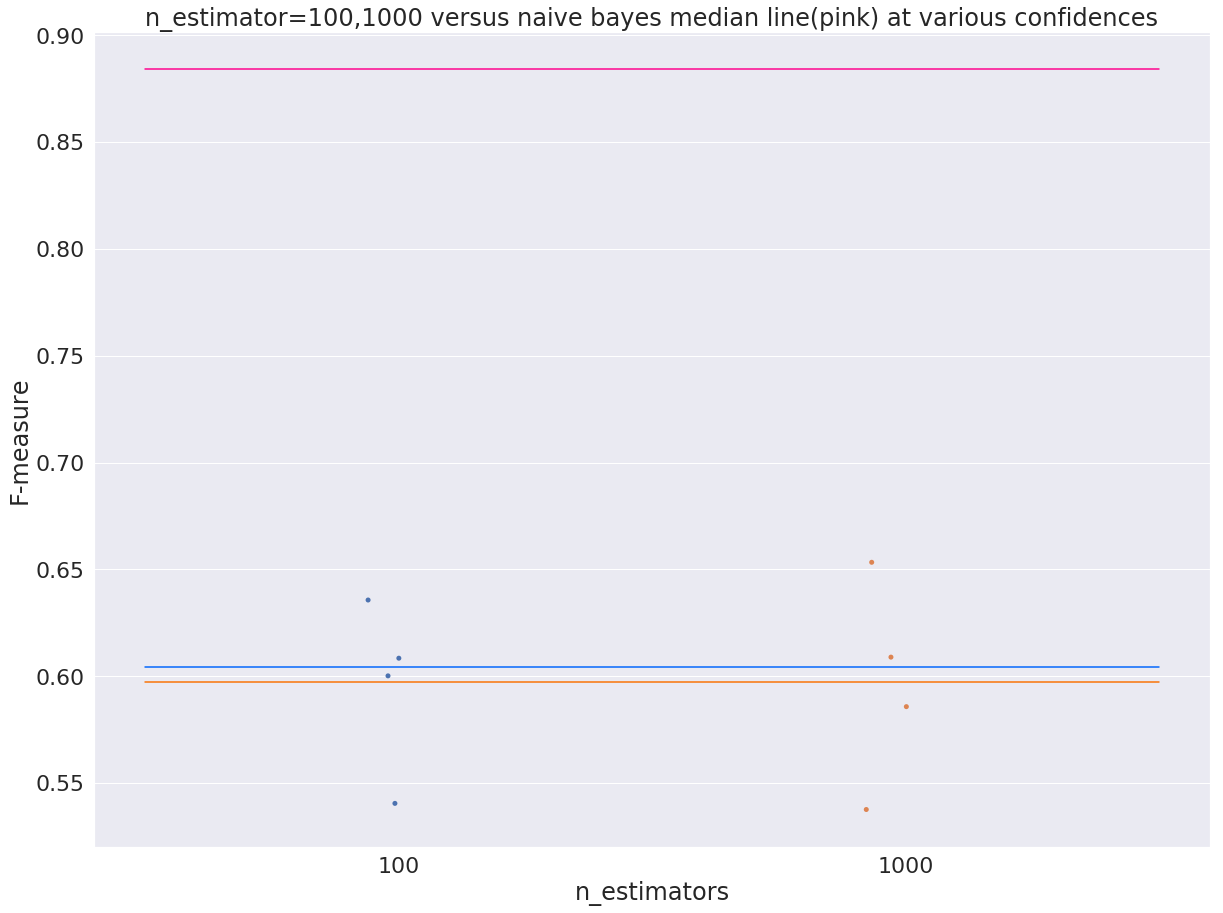

In [33]:
random_forest_nestimators = random_forest.sort_values('mean').head(8)
# naive bayes median line
nmed = naive_bayes.loc[naive_bayes['sample type'] == 'animal-distal-gut'].median()['F-measure']

# n_estimators median lines
xmed = random_forest_nestimators.loc[random_forest["n_estimators"] == 100].median()['F-measure']
ymed = random_forest_nestimators.loc[random_forest["n_estimators"] == 1000].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median = {0}'.format(nmed))
print('n_estimator=100 F-measure Median = {0}'.format(xmed))
print('n_estimator=1000 F-measure Median = {0}'.format(ymed))

sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
sns.stripplot(x='n_estimators', y='F-measure', data=random_forest_nestimators)


x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("n_estimator=100,1000 versus naive bayes median line(pink) at various confidences")
plt.show()

Naive Bayse F-measure Median = 0.8842083276799653
max_depth=16 F-measure Median = 0.6086974306765613
max_depth=64 F-measure Median = 0.7544085032010783
max_depth=none F-measure Median = 0.7605064463122456


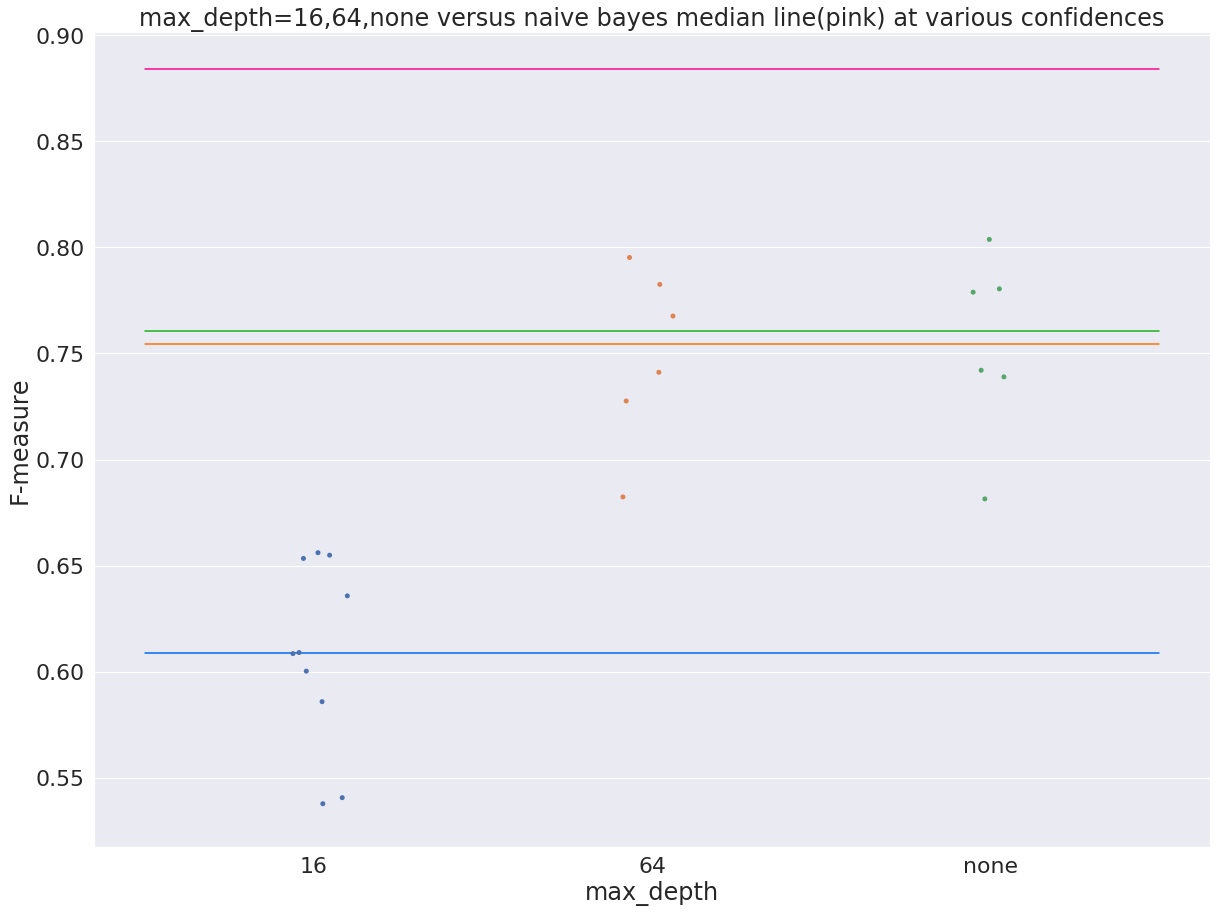

In [34]:
# naive bayes median line
nmed = naive_bayes.loc[naive_bayes['sample type'] == 'animal-distal-gut'].median()['F-measure']

# max_depth median lines
xmed = random_forest.loc[random_forest["max_depth"] == '16'].median()['F-measure']
ymed = random_forest.loc[random_forest["max_depth"] == '64'].median()['F-measure']
zmed = random_forest.loc[random_forest["max_depth"] == 'none'].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median = {0}'.format(nmed))
print('max_depth=16 F-measure Median = {0}'.format(xmed))
print('max_depth=64 F-measure Median = {0}'.format(ymed))
print('max_depth=none F-measure Median = {0}'.format(zmed))

sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
sns.stripplot(x='max_depth', y='F-measure', data=random_forest)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [zmed], sns.xkcd_rgb["green"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("max_depth=16,64,none versus naive bayes median line(pink) at various confidences")
plt.show()

Naive Bayse F-measure Median = 0.8842083276799653
max_features=sqrt F-measure Median = 0.6681483275669886
max_features=none F-measure Median = 0.7332908959547801


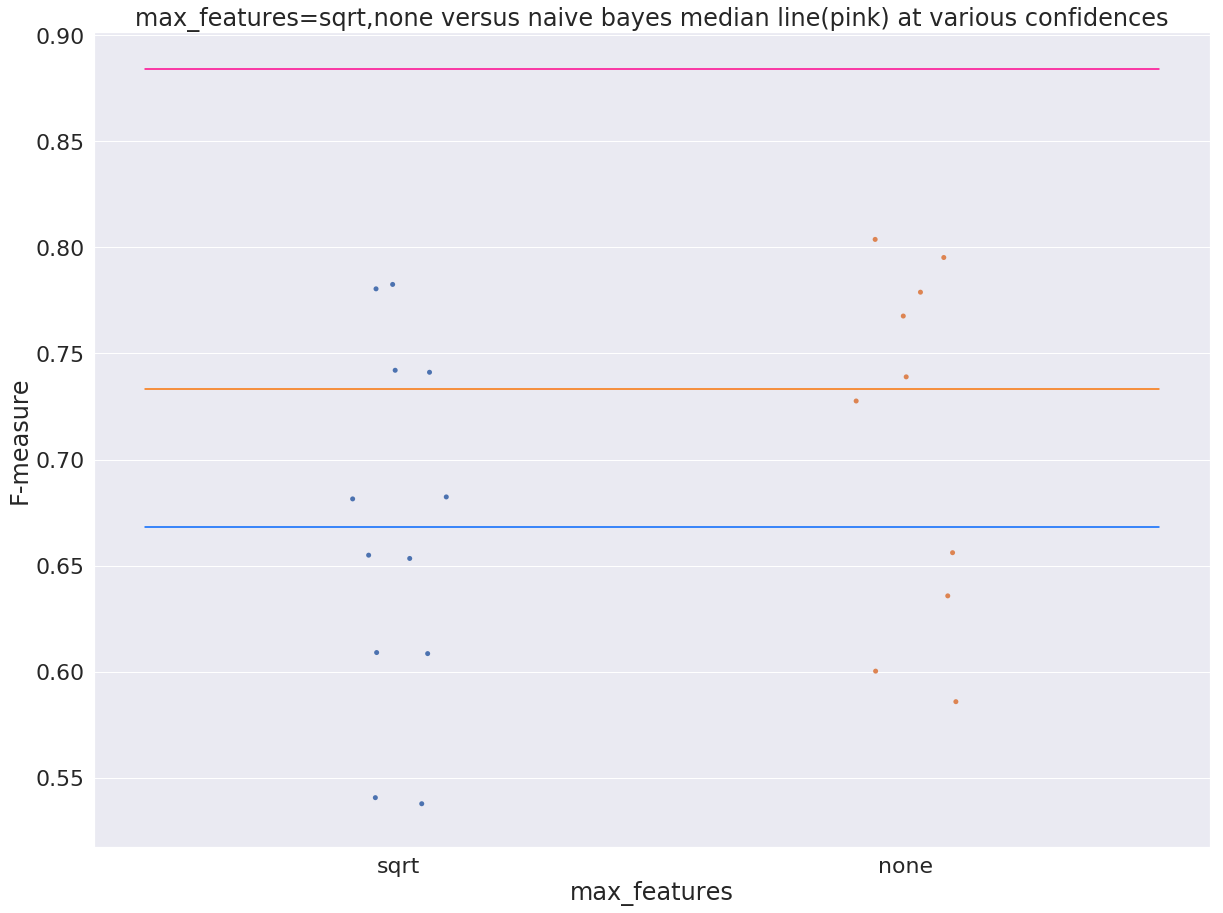

In [35]:
# naive bayes median line
nmed = naive_bayes.loc[naive_bayes['sample type'] == 'animal-distal-gut'].median()['F-measure']

# max_features median lines
xmed = random_forest.loc[random_forest["max_features"] == 'sqrt'].median()['F-measure']
ymed = random_forest.loc[random_forest["max_features"] == 'none'].median()['F-measure']

# print median values of each catagory
print('Naive Bayse F-measure Median = {0}'.format(nmed))
print('max_features=sqrt F-measure Median = {0}'.format(xmed))
print('max_features=none F-measure Median = {0}'.format(ymed))

sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)
sns.stripplot(x='max_features', y='F-measure', data=random_forest)

x = plt.gca().axes.get_xlim()

plt.plot(x, len(x) * [xmed], sns.xkcd_rgb["bright blue"])
plt.plot(x, len(x) * [ymed], sns.xkcd_rgb["orange"])
plt.plot(x, len(x) * [nmed], sns.xkcd_rgb["hot pink"])
plt.title("max_features=sqrt,none versus naive bayes median line(pink) at various confidences")
plt.show()

In [36]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new
for old, new in zip((6, 7), ('Genus', 'Species')):
    figure1.loc[figure1['level'] == old, 'level'] = new

In [21]:
%%R -i figure1
figure1$sample.type = factor(figure1$sample.type, levels=c(
 'Water (saline)',
 'Surface (saline)',
 'Sediment (saline)',
 'Water (non-saline)',
 'Surface (non-saline)',
 'Soil (non-saline)',
 'Sediment (non-saline)',
 'Plant rhizosphere',
 'Plant corpus',
 'Animal surface',
 'Animal secretion',
 'Animal proximal gut',
 'Animal distal gut',
 'Animal corpus'))
figure1$class.weights = factor(figure1$class.weights, levels=c(
    'Uniform', 'Average', 'Bespoke'
))
figure1$fill <- paste(figure1$level, figure1$class.weights)
figure1$fill <- factor(figure1$fill, levels=c(
  'Species Uniform',
  'Species Average',
  'Species Bespoke',
  'Genus Uniform',
  'Genus Average',
  'Genus Bespoke'))
fillPalette <- c("#56B4E9", "#009E73", "#E69F00", "#D4ECF9", "#BFE6DC", "#F8E7BF")
colourPalette <- c("#56B4E9", "#009E73", "#E69F00", "#56B4E9", "#009E73", "#E69F00")
p <- ggplot(data=figure1, aes(x=sample.type, y=mean)) +
  geom_col(data=figure1[figure1$level == 'Genus',], width=0.8, position=position_dodge(width=0.9),
           aes(colour=fill, fill=fill)) +
  geom_col(data=figure1[figure1$level == 'Species',], width=0.8, position=position_dodge(width=0.9),
           aes(colour=fill, fill=fill)) +
  geom_rect(ymin=0, ymax=0.635, xmin=-Inf, xmax=Inf, fill="white") +
  geom_errorbar(data=figure1[figure1$level == 'Species',],
                aes(ymin=lower, ymax=upper, fill=fill),
                width=0.4, position=position_dodge(width=0.9), alpha=0.5) +
  geom_errorbar(data=figure1[figure1$level == 'Genus',],
                aes(ymin=lower, ymax=upper, fill=fill),
                width=0.4, position=position_dodge(width=0.9), alpha=0.5) +
  coord_flip(ylim=c(0.65,0.95), clip="off") + 
  theme_bw() +
  labs(x='EMPO3 Habitat', y='F-measure') +
  scale_fill_manual(name='Level & Weights', values=fillPalette) +
  scale_colour_manual(name='Level & Weights', values=colourPalette) +
  theme(plot.margin = unit(c(1, 1, 2, 1), "lines"),
        axis.text.y = element_text(angle = 45)) +
  annotation_custom(
    grob=grid::textGrob(label = "Better Performance"),
    xmin=-0.5, xmax=-0.5, ymin=0.8, ymax=0.8
  ) + 
  annotation_custom(
    grob=linesGrob(arrow=arrow(type="open", ends="last", length=unit(2,"mm"))), 
    xmin=-0.3, xmax=-0.3, ymin=0.65, ymax=0.95
  ) 

ggsave(file="sr-f-measure.png", width=5, height=10, dpi=300)

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown aesthetics: fill

  warnings.warn(x, RRuntimeWarning)


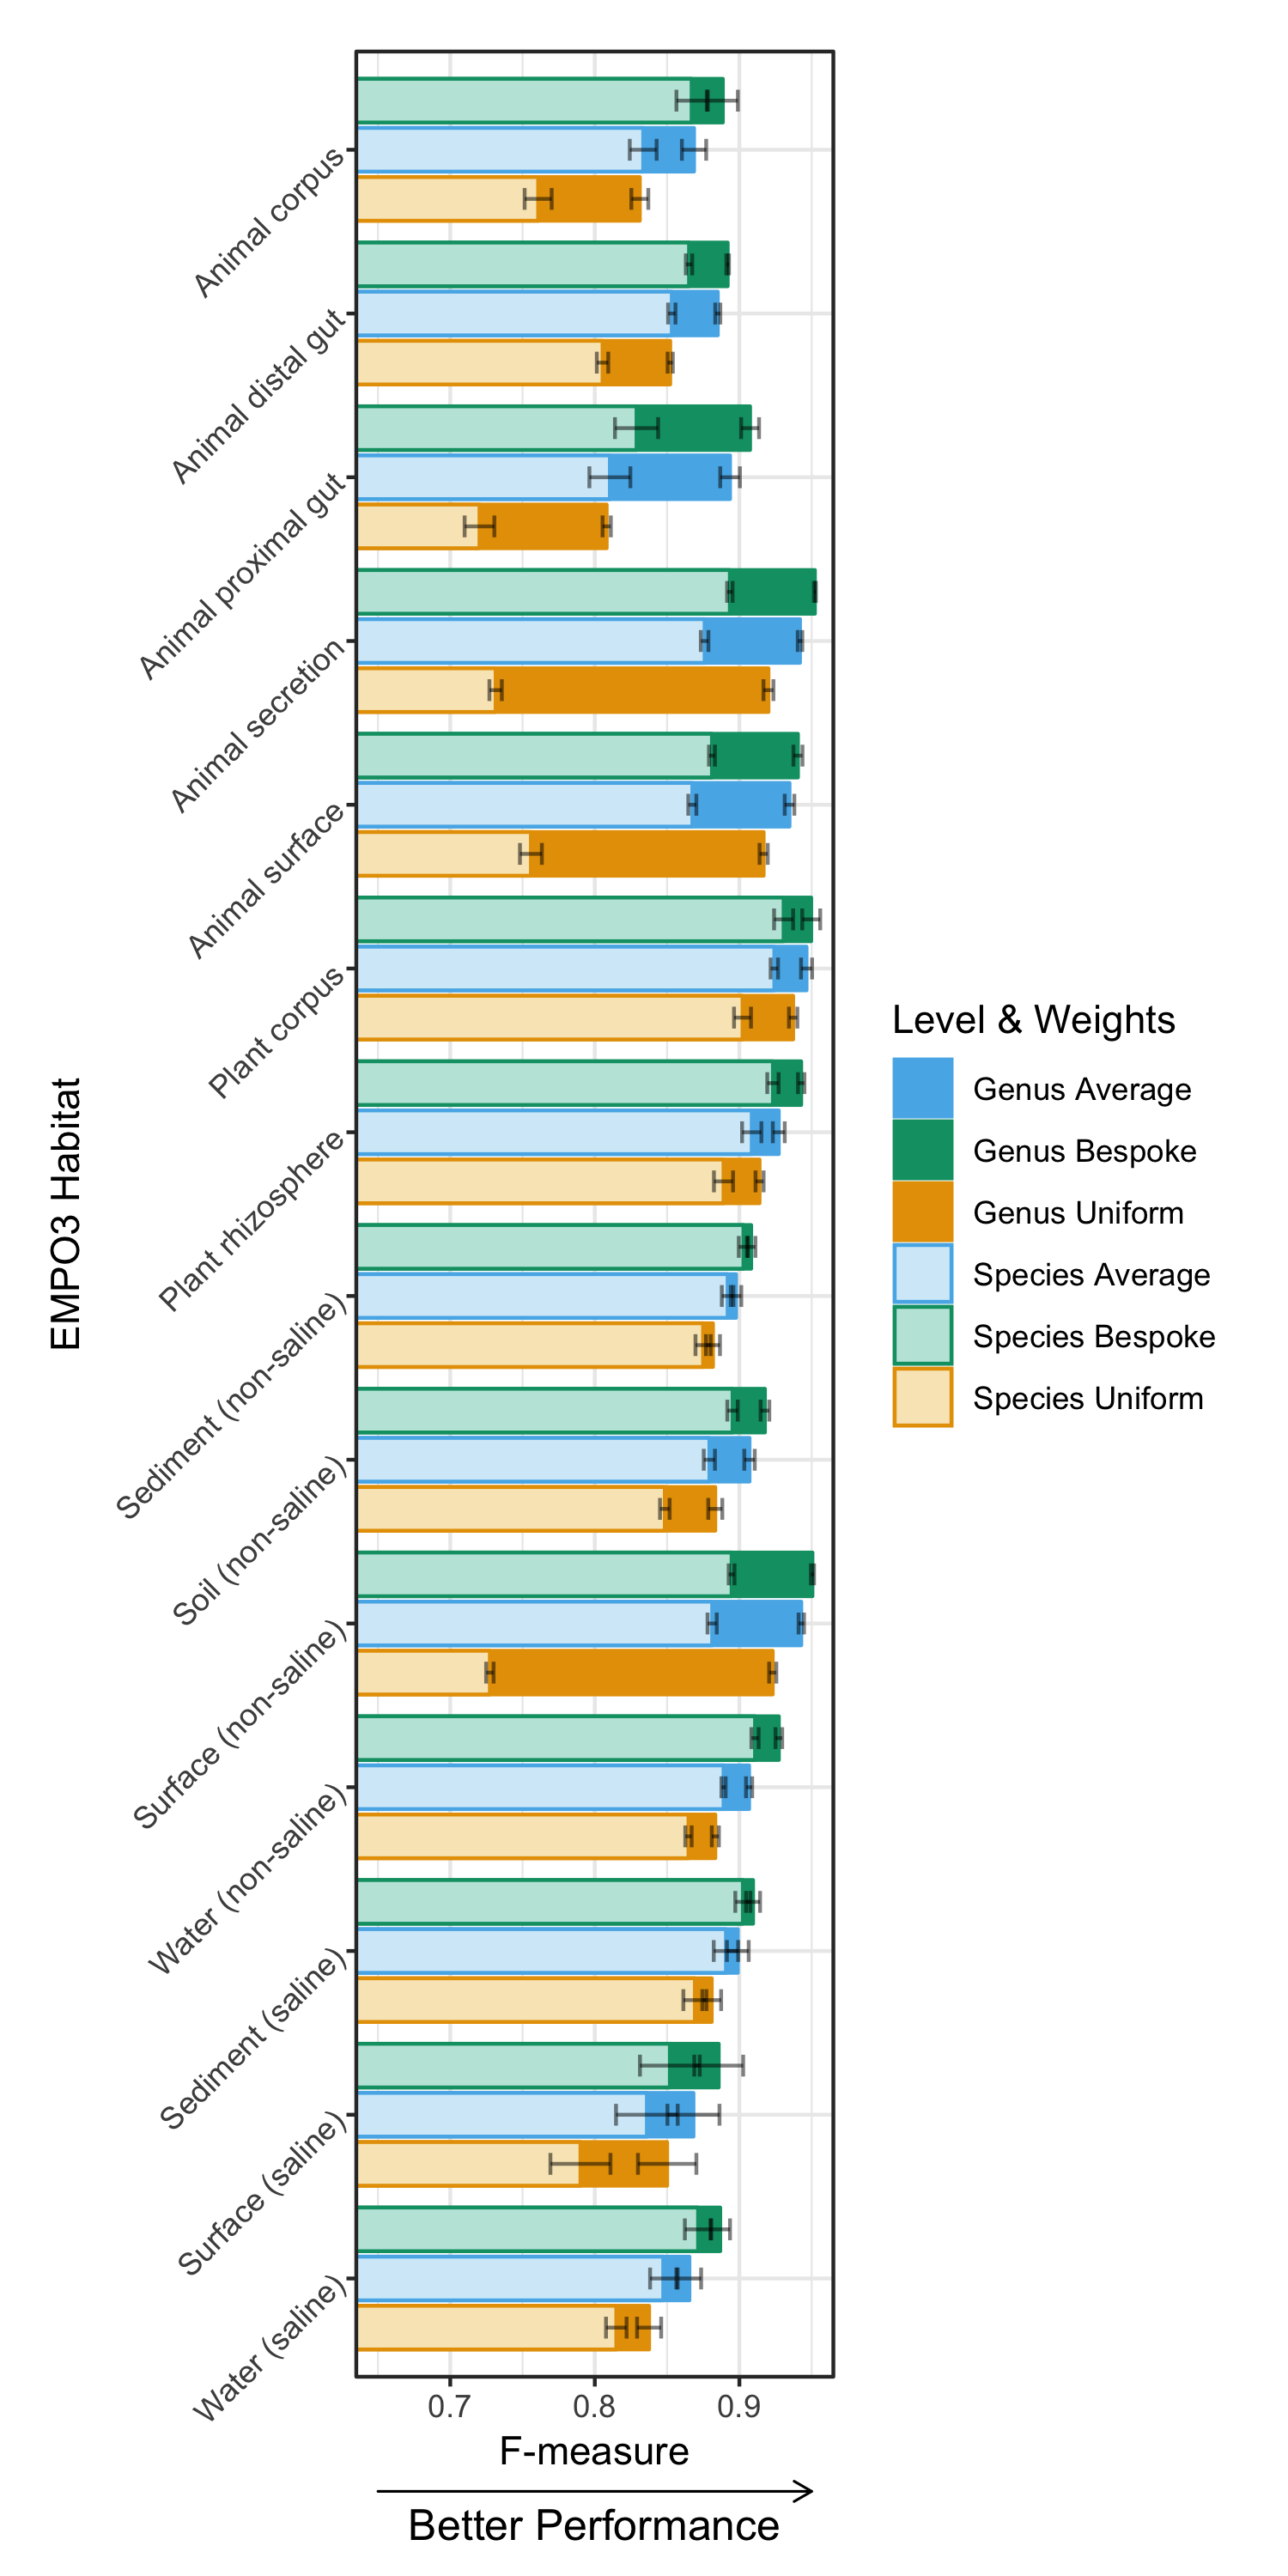

In [20]:
Image("sr-f-measure.png")

In [16]:
max(figure1['upper'] - figure1['lower'])

0.13128721225598428

In [17]:
bespoke = figure1[figure1['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure1[figure1['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.8288638081095409 0.9305880832502146
0.720229783917639 0.9021711163046009


In [18]:
len(set(level7['sample']))

21513

In [19]:
list(set(level7['sample']))[:10]

['11113.907.36782',
 '2192.H01a.Bedroom.Floor.268.lane2.NoIndex.L002.30619',
 '550.L6S38.s.6.sequence.30395',
 '550.L4S155.s.4.sequence.30395',
 '11113.686.36782',
 '11444.H4.fecal.none.1wk.43342',
 '10308.Fh.P4.IFF.B.10.30930',
 '1883.2005.21.Crump.Artic.LTREB.main.lane4.NoIndex.30612',
 '1024.SH004.C1.RH.1.161.flw.6.11.G1.L00.28362',
 '550.L4S165.s.4.sequence.30395']

In [20]:
len(set(_id.split('.')[1] for _id in level7['sample']))

7204

In [21]:
len(set(_id.split('.')[1] for _id in level7[level7['sample type']=='surface-saline']['sample']))

58

In [35]:
grouped = level7.groupby(['sample type', 'class weights', 'fold'])
def weighted_stats(x):
    d1 = DescrStatsW(x['Recall'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
grouped = precision.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
precision[(precision['class weights'] == 'bespoke70') | 
          (precision['class weights'] == 'uniform70')]

,sample type,class weights,mean,lower,upper
5,animal-corpus,bespoke70,0.834079,0.807420,0.860737
13,animal-corpus,uniform70,0.696828,0.671568,0.722089
21,animal-distal-gut,bespoke70,0.836902,0.830967,0.842838
29,animal-distal-gut,uniform70,0.761069,0.746696,0.775442
37,animal-proximal-gut,bespoke70,0.787296,0.752892,0.821699
45,animal-proximal-gut,uniform70,0.650310,0.628537,0.672082
53,animal-secretion,bespoke70,0.854664,0.851688,0.857641
61,animal-secretion,uniform70,0.639334,0.629122,0.649546
69,animal-surface,bespoke70,0.838421,0.831812,0.845030
77,animal-surface,uniform70,0.669983,0.647305,0.692661
